In [1]:
from functions import *
import torch

T = torch.tensor([1])
dt = torch.tensor([0.01])
S0 = torch.tensor([1])
q = torch.tensor([0.01])
A = torch.tensor([5, 5, 5])
B = torch.tensor([1, 1, 1])
Q = torch.tensor([300])
z = torch.tensor([10, 20, 30])
delta = torch.tensor([0.01])
gamma = torch.tensor([0.01])
sigma = torch.tensor([0.05])

# use cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T = T.to(device)
dt = dt.to(device)
S0 = S0.to(device)
q = q.to(device)
A = A.to(device)
B = B.to(device)
Q = Q.to(device)
z = z.to(device)
delta = delta.to(device)
gamma = gamma.to(device)
sigma = sigma.to(device)

In [4]:
# test the policy iteration
net = Net(3, 1, nn.ReLU()) # this is the policy net
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
losses_policy_iteration = []
for epoch in range(20):
    S, buy_orders, sell_orders, q, t, bid_vectors, ask_vectors = Train_Data_Simulation(T, dt, sigma, S0, A, B, Q, z, delta, gamma, net)
    loss = total_loss(net, S, q, t, dt, buy_orders, sell_orders, z, delta, Q, A, B, gamma)
    losses_policy_iteration.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch: ', epoch, 'loss: ', loss.item())
    

epoch:  0 loss:  38.88805389404297
epoch:  1 loss:  18455.65234375
epoch:  2 loss:  55.02914810180664
epoch:  3 loss:  33.3736686706543
epoch:  4 loss:  37.58096694946289
epoch:  5 loss:  22.276412963867188
epoch:  6 loss:  31.814891815185547
epoch:  7 loss:  50.69807052612305
epoch:  8 loss:  34.57612609863281
epoch:  9 loss:  35.5031623840332
epoch:  10 loss:  39.32980728149414
epoch:  11 loss:  39.12005615234375
epoch:  12 loss:  48.12982940673828
epoch:  13 loss:  48.14130401611328
epoch:  14 loss:  22.061229705810547
epoch:  15 loss:  25.777503967285156
epoch:  16 loss:  25.27523422241211
epoch:  17 loss:  59.64814376831055
epoch:  18 loss:  15.156120300292969
epoch:  19 loss:  49.42002868652344


In [11]:
# test the trained net on the simulation data
from functions import *
trajectory = []
for _ in range(10):
    S, buy_orders, sell_orders, q, t, bid_vectors, ask_vectors = Train_Data_Simulation(T, dt, sigma, S0, A, B, Q, z, delta, gamma, net)
    N = int(T / dt)
    r = torch.zeros(N, device = device)
    for i in range(N - 1):
        hold1 = z * buy_orders[i] * bid_vectors[i]
        hold2 = z * sell_orders[i] * ask_vectors[i]
        r[i] = torch.sum(hold1) + torch.sum(hold2)
        r[i] = r[i] + (q[i + 1] * S[i + 1] - q[i] * S[i]) - delta * h(q[i], Q) * (q[i + 1] - q[i])

    trajectory.append(torch.sum(r).item())
    

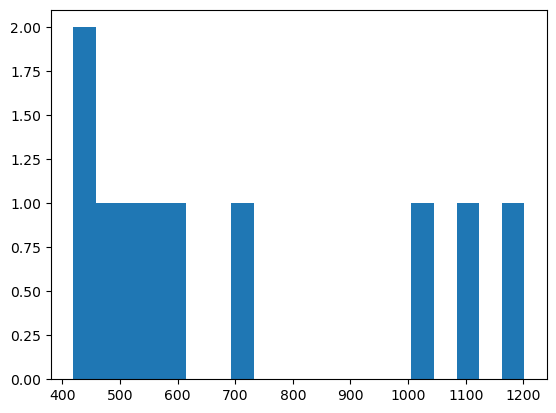

In [13]:
# draw histogram about the trajectory
import matplotlib.pyplot as plt
plt.hist(trajectory, bins = 20)
plt.show()



In [16]:
# test the actor-critic method

policy_net = Net(3, 6, nn.Sigmoid()) 
value_net = Net(3, 1, nn.ReLU())
policy_net.to(device)
value_net.to(device)
optimizer_policy = torch.optim.Adam(policy_net.parameters(), lr=0.01)
optimizer_value = torch.optim.Adam(value_net.parameters(), lr=0.01)
losses_actor_critic = []
for epoch in range(20):
    S, buy_orders, sell_orders, q, t, bid_vectors, ask_vectors = Test_Data_Simulation_Stochastic(T, dt, sigma, S0, policy_net, A, B, gamma, z)
    v_loss = critic_loss(policy_net, value_net, S, q, t, buy_orders, sell_orders, T, dt, A, B, gamma, delta, z, Q)
    p_loss = policy_loss(policy_net, value_net, S, q, t, buy_orders, sell_orders, bid_vectors, ask_vectors, T, dt, A, B, gamma, delta, z, Q)
    # when we train the policy net, we need to detach the value net
    loss = v_loss + p_loss
    losses_actor_critic.append(loss.item())
    optimizer_policy.zero_grad()
    optimizer_value.zero_grad()
    loss.backward()
    optimizer_policy.step()
    optimizer_value.step()
    print('epoch: ', epoch, 'loss: ', loss.item())

    
    
    

epoch:  0 loss:  6794.853515625
epoch:  1 loss:  3131.518798828125
epoch:  2 loss:  5849.8134765625
epoch:  3 loss:  2256.614013671875
epoch:  4 loss:  4546.5625
epoch:  5 loss:  3699.296875
epoch:  6 loss:  4991.599609375
epoch:  7 loss:  12795.5791015625
epoch:  8 loss:  3758.312744140625
epoch:  9 loss:  4100.73779296875
epoch:  10 loss:  2579.586669921875
epoch:  11 loss:  5823.0869140625
epoch:  12 loss:  3742.810791015625
epoch:  13 loss:  2971.39208984375
epoch:  14 loss:  2314.858642578125
epoch:  15 loss:  4550.513671875
epoch:  16 loss:  2846.587646484375
epoch:  17 loss:  2710.486328125
epoch:  18 loss:  4431.3271484375
epoch:  19 loss:  6411.52197265625


In [17]:
trajectory_actor_critic = []
for _ in range(10):
    S, buy_orders, sell_orders, q, t, bid_vectors, ask_vectors = Test_Data_Simulation_Stochastic(T, dt, sigma, S0, policy_net, A, B, gamma, z)
    N = int(T / dt)
    r = torch.zeros(N, device = device)
    for i in range(N - 1):
        hold1 = z * buy_orders[i] * bid_vectors[i]
        hold2 = z * sell_orders[i] * ask_vectors[i]
        r[i] = torch.sum(hold1) + torch.sum(hold2)
        r[i] = r[i] + (q[i + 1] * S[i + 1] - q[i] * S[i]) - delta * h(q[i], Q) * (q[i + 1] - q[i])

    trajectory_actor_critic.append(torch.sum(r).item())

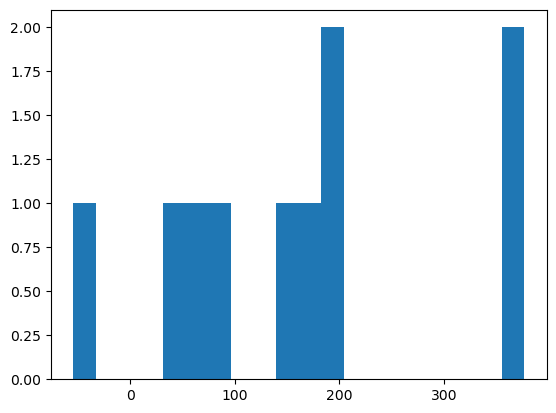

In [19]:
plt.hist(trajectory_actor_critic, bins = 20)
plt.show()